In [27]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

# Import some extra modules
import re

# Import data visualisation modules.
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Port in and unpack all the runs we need from the .pkl file.
train_set_na = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_na+.pkl')
train_set_cl = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/cambridge/ai4er/easter/mres/CrunchFlow_Work/bcm/2022-05-27_bcm_4-0/basalt_cl-.pkl')

In [29]:
# Rename all the keys in train_set_cl so that they follow on
# from the previous dictionary; this allows merging
train_set_na_len = len(train_set_na.keys())
train_set_cl_arr = []
for key in train_set_cl.keys():
    train_set_cl_arr.append(key)

for _ in train_set_cl_arr:
    old_key = _
    new_key = _ + train_set_na_len
    train_set_cl[new_key] = train_set_cl[old_key]
    del train_set_cl[old_key]

In [30]:
train_set = train_set_na | train_set_cl
# Filter any error filled runs
dataset, error = hp.filter_errors(train_set)

Returned 5316 files without errors out of a total possible 10000.
4684 files had errors.
0 files had unhandled errors.
File failure rate: 88.11136192626034 %.
To see unhandled errors, run with verbose=True.


In [31]:
attributes = attr.get_condition(dataset,"basalt",species_concs=True)
attributes = attributes.loc[:, ['Ca++', 'Fe++', 'Mg++', 'HCO3-']]
attributes

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,Ca++,Fe++,Mg++,HCO3-
0,0.000030,0.000262,0.000121,0.82
1,0.000071,0.000244,0.000245,0.82
2,0.000183,0.000048,0.000124,0.82
3,0.000157,0.000085,0.000127,0.82
4,0.000053,0.000019,0.000237,0.82
...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82
5312,0.000245,0.000107,0.000123,0.82
5313,0.000176,0.000031,0.000255,0.82
5314,0.000272,0.000215,0.000171,0.82


In [32]:
def get_condition_ph(dataset, condition):
    index_vals = []
    ph_vals = []
    for _ in dataset.keys():
        index_vals.append(_)
        ph_vals.append(dataset[_].condition_blocks[condition].contents['pH'])
    ph_df = pd.DataFrame(ph_vals, index=index_vals, columns=['pH'])
    ph_df = ph_df.reset_index(drop=True)
    return ph_df

ph_df = get_condition_ph(dataset, "basalt")

attributes =  pd.concat([attributes, ph_df], axis=1)
attributes

,Ca++,Fe++,Mg++,HCO3-,pH
0,0.000030,0.000262,0.000121,0.82,4.533987010208772
1,0.000071,0.000244,0.000245,0.82,4.6355729656454905
2,0.000183,0.000048,0.000124,0.82,4.266688527662164
3,0.000157,0.000085,0.000127,0.82,4.93744987421191
4,0.000053,0.000019,0.000237,0.82,4.320066725459632
...,...,...,...,...,...
5311,0.000263,0.000020,0.000210,0.82,3.5183910175187125
5312,0.000245,0.000107,0.000123,0.82,3.036155925072882
5313,0.000176,0.000031,0.000255,0.82,3.4486894430649
5314,0.000272,0.000215,0.000171,0.82,3.747021276313699


In [33]:
def NrFormatFixer_XYZTime(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for ____ in xr_DataSet.time.values:
                    for _____ in xr_DataSet.data_vars:
                        xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}',time=f'{____}')]
                        for ______ in range(0,len(xr_DataArray)):
                            string = str(xr_DataArray.values[______])
                            new_val = string
                            if re.match("^\d+\.\d+-\d+$",string):
                                i_rev = 1
                                str_len = len(string)
                                for _______ in reversed(string):
                                    if _______ == "-":
                                        break
                                    else:
                                        i_rev+=1
                                        continue
                                i = str_len - i_rev
                                new_string = string[:i] + "e" + string[i:]
                                new_val = new_string
                            xr_DataArray.values[______] = new_val
    return xr_DataSet

In [34]:
def NrFormatFixer_XYZ(xr_DataSet):
    for _ in xr_DataSet.X.values:
        for __ in xr_DataSet.Y.values:
            for ___ in xr_DataSet.Z.values:
                for _____ in xr_DataSet.data_vars:
                    xr_DataArray = xr_DataSet[f'{_____}'].loc[dict(X=f'{_}',Y=f'{__}',Z=f'{___}')]
                    for ______ in range(0,len(xr_DataArray)):
                        string = str(xr_DataArray.values[______])
                        new_val = string
                        if re.match("^\d+\.\d+-\d+$",string):
                            i_rev = 1
                            str_len = len(string)
                            for _______ in reversed(string):
                                if _______ == "-":
                                    break
                                else:
                                    i_rev+=1
                                    continue
                            i = str_len - i_rev
                            new_string = string[:i] + "e" + string[i:]
                            new_val = new_string
                        xr_DataArray.values[______] = new_val
    return xr_DataSet

In [35]:
final_vols = lbls.raw(dataset, 'volume')
final_vols = NrFormatFixer_XYZTime(final_vols)
final_vols = final_vols.astype(float)

In [36]:
initial_vols = attr.initial_conditions(dataset, concentrations=False, minerals=True)
initial_vols = NrFormatFixer_XYZ(initial_vols)
initial_vols = initial_vols.astype(float)

In [37]:
delt_vf = final_vols - initial_vols
delt_vf

<xarray.Dataset>
Dimensions:       (X: 1, Y: 1, Z: 1, time: 28, file_num: 5316)
Coordinates:
  * X             (X) float64 0.5
  * Y             (Y) float64 0.5
  * Z             (Z) float64 0.5
  * time          (time) float64 0.01 0.02 0.03 0.04 0.05 ... 7.0 8.0 9.0 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num, time, X, Y, Z) float64 -5.975e-06 ... 0.000327
    Hedenbergite  (file_num, time, X, Y, Z) float64 -3.904e-06 ... -0.0003348
    Albite        (file_num, time, X, Y, Z) float64 1.546e-05 ... 1.73e-05
    Anorthite     (file_num, time, X, Y, Z) float64 -2.794e-06 ... -3.734e-06
    M_Microcline  (file_num, time, X, Y, Z) float64 1.89e-07 ... 2.21e-07
    Forsterite    (file_num, time, X, Y, Z) float64 -0.0002667 ... -0.001733
    Fayalite      (file_num, time, X, Y, Z) float64 -0.0001294 ... 5.071e-05
    Calcite       (file_num, time, X, Y, Z) float64 -8.931e-11 ... -1e-10
    Magnesite     (file_num, time, X, Y, Z) float64 1.917e-12 ... 0.001867
    Siderite      (file_num, time, X, Y, Z) float64 0.0001662 ... 8.027e-05

In [38]:
delt_vf_TenYr = delt_vf.sel(X=0.5,Y=0.5,Z=0.5,time=10)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 5316)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.0003505 0.0003612 ... 0.0003281 0.000327
    Hedenbergite  (file_num) float64 -0.0003315 -0.0003304 ... -0.0003348
    Albite        (file_num) float64 9.903e-05 0.0001341 ... 1.73e-05 1.73e-05
    Anorthite     (file_num) float64 -4.482e-05 -6.244e-05 ... -3.734e-06
    M_Microcline  (file_num) float64 2.2e-07 2.2e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001725 -0.001723 ... -0.001734 -0.001733
    Fayalite      (file_num) float64 5.12e-05 5.127e-05 ... 5.074e-05 5.071e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001868 0.001869 ... 0.001867 0.001867
    Siderite      (file_num) float64 7.847e-05 7.784e-05 ... 8.035e-05 8.027e-05

In [39]:
delt_vf_TenYr = delt_vf_TenYr.assign(Carbonates=lambda delt_vf_TenYr: delt_vf_TenYr.Calcite + delt_vf_TenYr.Siderite + delt_vf_TenYr.Magnesite)
delt_vf_TenYr

<xarray.Dataset>
Dimensions:       (file_num: 5316)
Coordinates:
    X             float64 0.5
    Y             float64 0.5
    Z             float64 0.5
    time          float64 10.0
Dimensions without coordinates: file_num
Data variables:
    Diopside      (file_num) float64 0.0003505 0.0003612 ... 0.0003281 0.000327
    Hedenbergite  (file_num) float64 -0.0003315 -0.0003304 ... -0.0003348
    Albite        (file_num) float64 9.903e-05 0.0001341 ... 1.73e-05 1.73e-05
    Anorthite     (file_num) float64 -4.482e-05 -6.244e-05 ... -3.734e-06
    M_Microcline  (file_num) float64 2.2e-07 2.2e-07 ... 2.21e-07 2.21e-07
    Forsterite    (file_num) float64 -0.001725 -0.001723 ... -0.001734 -0.001733
    Fayalite      (file_num) float64 5.12e-05 5.127e-05 ... 5.074e-05 5.071e-05
    Calcite       (file_num) float64 -1e-10 -1e-10 -1e-10 ... -1e-10 -1e-10
    Magnesite     (file_num) float64 0.001868 0.001869 ... 0.001867 0.001867
    Siderite      (file_num) float64 7.847e-05 7.784e-05 ... 8.035e-05 8.027e-05
    Carbonates    (file_num) float64 0.001946 0.001946 ... 0.001947 0.001947

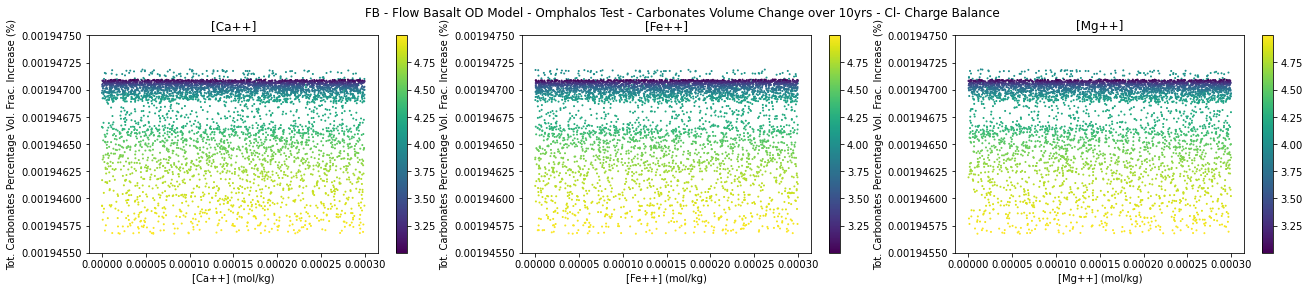

In [101]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Carbonates Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(22)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax1.set_ylim(bottom=0.0019455, top=0.0019475)
ax2.set_ylim(bottom=0.0019455, top=0.0019475)
ax3.set_ylim(bottom=0.0019455, top=0.0019475)

ax1_x = attributes["Ca++"].values
ax1_y = delt_vf_TenYr.Carbonates.values
ax1_c = attributes['pH'].values.astype(float)
ax2_x = attributes["Fe++"].values
ax2_y = delt_vf_TenYr.Carbonates.values
ax2_c = attributes['pH'].values.astype(float)
ax3_x = attributes["Mg++"].values
ax3_y = delt_vf_TenYr.Carbonates.values
ax3_c = attributes['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x,y=ax1_y,c=ax1_c,s=1,cmap = "viridis")
im2 = ax2.scatter(x=ax2_x,y=ax2_y,c=ax2_c,s=1,cmap = "viridis")
im3 = ax3.scatter(x=ax3_x,y=ax3_y,c=ax3_c,s=1,cmap = "viridis")
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

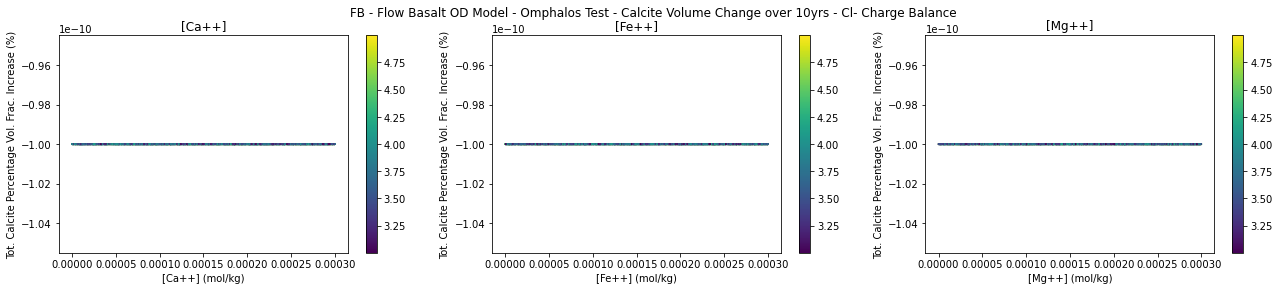

In [100]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Calcite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(22)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax1.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

ax1_x = attributes["Ca++"].values
ax1_y = delt_vf_TenYr.Calcite.values
ax1_c = attributes['pH'].values.astype(float)
ax2_x = attributes["Fe++"].values
ax2_y = delt_vf_TenYr.Calcite.values
ax2_c = attributes['pH'].values.astype(float)
ax3_x = attributes["Mg++"].values
ax3_y = delt_vf_TenYr.Calcite.values
ax3_c = attributes['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, s=1, c=ax1_c, cmap='viridis')
im2 = ax2.scatter(x=ax2_x, y=ax2_y, s=1, c=ax2_c, cmap='viridis')
im3 = ax3.scatter(x=ax3_x, y=ax3_y, s=1, c=ax3_c, cmap='viridis')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

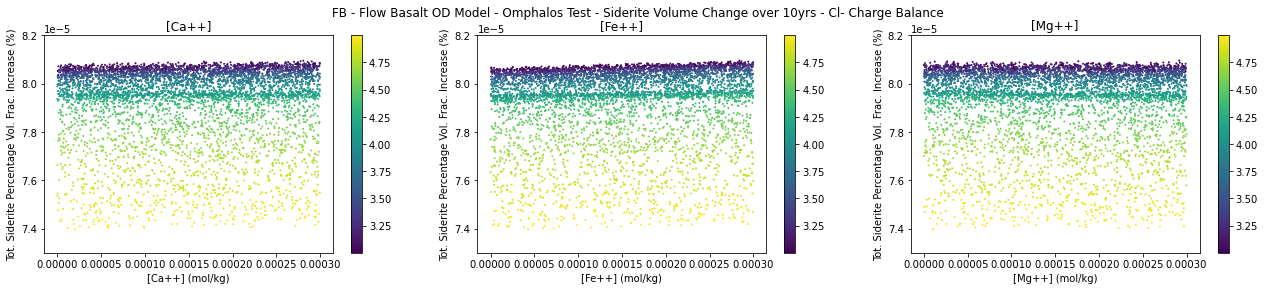

In [99]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Siderite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(22)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax1.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax1.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax2.set_ylim(bottom=7.3e-5, top=8.2e-5)
ax3.set_ylim(bottom=7.3e-5, top=8.2e-5)

ax1_x = attributes["Ca++"].values
ax1_y = delt_vf_TenYr.Siderite.values
ax1_c = attributes['pH'].values.astype(float)
ax2_x = attributes["Fe++"].values
ax2_y = delt_vf_TenYr.Siderite.values
ax2_c = attributes['pH'].values.astype(float)
ax3_x = attributes["Mg++"].values
ax3_y = delt_vf_TenYr.Siderite.values
ax3_c = attributes['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, s=1, c=ax1_c, cmap='viridis')
im2 = ax2.scatter(x=ax2_x, y=ax2_y, s=1, c=ax2_c, cmap='viridis')
im3 = ax3.scatter(x=ax3_x, y=ax3_y, s=1, c=ax3_c, cmap='viridis')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

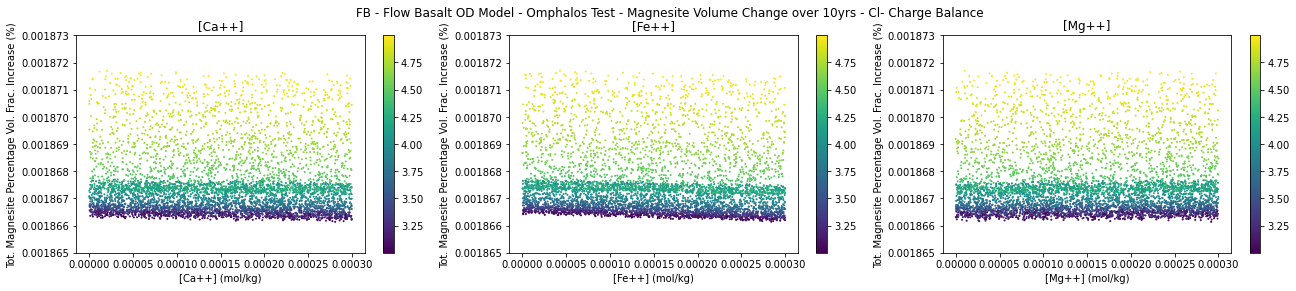

In [98]:
fig, ((ax1),(ax2),(ax3)) = plt.subplots(1,3)
fig.suptitle('FB - Flow Basalt OD Model - Omphalos Test - Magnesite Volume Change over 10yrs - Cl- Charge Balance')

fig.set_figheight(4)
fig.set_figwidth(22)

ax1.set_title("[Ca++]")
ax2.set_title("[Fe++]")
ax3.set_title("[Mg++]")
ax1.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax2.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax3.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')
ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')
ax1.set_ylim(bottom=0.001865, top=0.001873)
ax2.set_ylim(bottom=0.001865, top=0.001873)
ax3.set_ylim(bottom=0.001865, top=0.001873)

ax1_x = attributes["Ca++"].values
ax1_y = delt_vf_TenYr.Magnesite.values
ax1_c = attributes['pH'].values.astype(float)
ax2_x = attributes["Fe++"].values
ax2_y = delt_vf_TenYr.Magnesite.values
ax2_c = attributes['pH'].values.astype(float)
ax3_x = attributes["Mg++"].values
ax3_y = delt_vf_TenYr.Magnesite.values
ax3_c = attributes['pH'].values.astype(float)

im1 = ax1.scatter(x=ax1_x, y=ax1_y, s=1, c=ax1_c, cmap='viridis')
im2 = ax2.scatter(x=ax2_x, y=ax2_y, s=1, c=ax2_c, cmap='viridis')
im3 = ax3.scatter(x=ax3_x, y=ax3_y, s=1, c=ax3_c, cmap='viridis')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)